In [ ]:
SEED = 1212028

# Initialization

In [ ]:
import local.utils as utils

utils.deterministic_environment(SEED)

# Determine global device
device = utils.get_torch_device()
print("Device `{}` for computations with PyTorch".format(device))

# Dataset Preparation

In [ ]:
import os

ROOT = os.path.abspath(".")
DIODE_ROOT = os.path.join(ROOT, "diode")
DATASET_PATH = os.path.join(DIODE_ROOT, "val", "indoors")
DATASET_OUTDOORS_PATH = os.path.join(DIODE_ROOT, "val", "outdoor")

In [ ]:
from local.diode.utils import get_filelist, format_filelist
import pandas as pd

# DataFrame storage with initial shuffling for train/valid split
data = pd.DataFrame(format_filelist(get_filelist(DATASET_PATH)))
data = data.sample(frac=1, random_state=SEED)

In [ ]:
import math

split = math.floor(len(data) * 0.8)
train = data[:split]
valid = data[split:]

# Model Creation

In [ ]:
import torch

# DenseNet from PyTorch Hub
densenet = torch.hub.load(
    'pytorch/vision:v0.10.0', 'densenet169', 
    pretrained=True,
)

# Freeze DenseNet model parameters
for param in densenet.parameters():
    param.requires_grad = False

In [ ]:
intermediate_outputs = {}

def store_input(layer):
    def hook(module, input):
        intermediate_outputs[layer] = input[0].detach()
    return hook

def store_output(layer):
    def hook(module, input, output):
        intermediate_outputs[layer] = output.detach()
    return hook

# C x H x W
densenet.features.register_forward_pre_hook(store_input("input"))
# 64 x H/2 x W/2
densenet.features.relu0.register_forward_hook(store_output("relu0"))
# 64 x H/4 x W/4
densenet.features.pool0.register_forward_hook(store_output("pool0"))
# 128 x H/8 x W/8
densenet.features.transition1.register_forward_hook(store_output("transition1"))
# 256 x H/16 x W/16
densenet.features.transition2.register_forward_hook(store_output("transition2"))
# # 640 x H/32 x W/32
# densenet.features.transition3.register_forward_hook(store_output("transition3"))

In [ ]:
import torch.nn as nn

class SkipConnection(nn.Module):
    def __init__(self, module, context):
        super().__init__()
        self._context = context
        self._module = module

    def __call__(self, x):
        if self._context in intermediate_outputs:
            _context_value = intermediate_outputs[self._context]
            x = torch.concat(
                (x, _context_value), dim=1
            )

        return self._module(x)


class Upsampler(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size=(3, 3), stride=(1, 1), concat_with=None):
        super().__init__()
        self._context = concat_with
        self._upsampler = nn.Sequential(
            nn.Upsample(scale_factor=2),
        )

        self._model = nn.Sequential(
            nn.Conv2d(in_filters, out_filters, kernel_size=kernel_size, stride=stride, padding="same"),
            nn.Conv2d(out_filters, out_filters, kernel_size=kernel_size, stride=stride, padding="same"),
            nn.BatchNorm2d(out_filters),
            nn.LeakyReLU(0.2),
        )

        if concat_with is not None:
            self._model = SkipConnection(self._model, concat_with)

    def __call__(self, x):
        x = self._upsampler(x)
        return self._model(x)


# "Decoder" that takes extracted features from the DenseNet and generates
#     a depth map
class DecoderModel(nn.Module):
    def __init__(self, features=1664):
        super().__init__()

        self._model = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(features, features, kernel_size=1, stride=1, padding="same"),

            Upsampler(features//1 + 256, features//2, kernel_size=3, stride=1, concat_with="transition2"),
            Upsampler(features//2 + 128, features//4, kernel_size=3, stride=1, concat_with="transition1"),
            Upsampler(features//4 + 64, features//8, kernel_size=3, stride=1, concat_with="pool0"),
            Upsampler(features//8 + 64, features//16, kernel_size=3, stride=1, concat_with="relu0"),

            # Additional upsampler to go back to the original resolution
            Upsampler(features//16 + 3, features//16, kernel_size=3, stride=1, concat_with="input"),

            nn.Conv2d(features//16, 1, kernel_size=3, stride=1, padding="same"),
        )

    def forward(self, x):
        return self._model(x)

In [ ]:
# The model used in this project
depth_decoder = DecoderModel()
model = nn.Sequential(densenet.features, depth_decoder)

# Model Summaries

In [ ]:
from torchinfo import summary

In [ ]:
summary(densenet, input_size=(1, 3, 768, 1024))

In [ ]:
summary(model, input_size=(1, 3, 768, 1024), depth=8)

# Training

In [ ]:
from local.diode.dataset import DIODEDataset
from local.diode.transforms import DepthNorm, MinMaxScaler
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, Grayscale, Normalize, ToTensor

base_preprocess = Compose([
    # Convert to PyTorch Tensor
    ToTensor(),
])

image_preprocess = Compose([
    Grayscale(num_output_channels=3),
    # Normalize input data
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

depth_preprocess = Compose([
    # Clip maximum depth
    DepthNorm(1000.0),
])

# Create datasets
datasets = {"train": train, "valid": valid}
datasets = {
    k: DIODEDataset(
        v, 
        image_transform=Compose([base_preprocess, image_preprocess]),
        depth_transform=Compose([base_preprocess, depth_preprocess]),
    ) 
    for k, v in datasets.items()
}

# Create DataLoaders for batch processing
dataloaders = {
    k: DataLoader(v, batch_size=2, shuffle=True, num_workers=2) 
    for k, v in datasets.items()
}

In [ ]:
import torch.nn as nn
from local.loss import ssim, depth_smoothness, weighted_loss

criterion = weighted_loss.WeightedLoss(
  [
    ssim.MaximumSSIMLoss(k1=0.01 * 2, k2=0.03 * 2, value_range=1000.0),
    nn.MSELoss(),
    depth_smoothness.InverseDepthSmoothnessLoss(),
  ],
  weights=[1.0, 0.1, 1.0],
)

In [ ]:
from torch import optim

optimizer = optim.Adam(depth_decoder.parameters(), lr=1e-2)
# Decay learning rate by 0.01 every 10 epochs
adaptive_lr = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.01)

In [ ]:
import time


def train_model(model, criterion, optimizer, scheduler, epochs=50):
    best_loss = {phase: 1e6 for phase in ["train", "valid"]}

    model = model.to(device)
    criterion = criterion.to(device)
    for epoch in range(1, epochs + 1):
        print(f"Epoch {epoch}/{epochs}")
        print('-' * 10)

        # Training and validation phases
        for phase in ["train", "valid"]:
            dataset_loader = dataloaders[phase]

            if phase == "train":
                model.train()
            elif phase == "valid":
                model.eval()

            phase_tick = time.time()
            phase_loss = 0.0
            phase_total = 0

            for batch in dataset_loader:
                input, target = batch["input"], batch["target"]

                input = input.to(device)
                target = target.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    output = model(input)

                    # Repeat channels by 3
                    output = torch.repeat_interleave(output, 3, axis=1)
                    target = torch.repeat_interleave(target, 3, axis=1)

                    loss = criterion(target, output)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                
                phase_loss = phase_loss + loss * input.shape[0]
                phase_total = phase_total + input.shape[0]

            if phase == "train":
                scheduler.step()

            phase_time_diff = time.time() - phase_tick
            epoch_loss = phase_loss / phase_total
            print("{} Loss: {:.4f} - {} minute(s) {:.4f} second(s)".format(
                phase, epoch_loss, phase_time_diff // 60, phase_time_diff % 60
            ))

            best_phase_loss = best_loss[phase]
            if epoch_loss < best_phase_loss:
                best_loss[phase] = epoch_loss
                torch.save(model.state_dict(), "model_{}.pth".format(phase))
        
        print()

    # Load best model state
    model = model.cpu()
    criterion = criterion.cpu()
    return model

In [ ]:
train_model(model, criterion, optimizer, adaptive_lr, epochs=30)

In [ ]:
torch.save(model.state_dict(), 'model_final.pth')

# Evaluating Model

In [ ]:
model.load_state_dict(torch.load('model_valid.pth', map_location=torch.device('cpu')))
model.eval()

In [ ]:
from local.diode.utils import get_filelist, format_filelist
import pandas as pd

# Let's see the performance generalizing in a completely different environment
#   from training, outdoors versus indoors
test = pd.DataFrame(format_filelist(get_filelist(DATASET_OUTDOORS_PATH)))
test = test.sample(frac=1, random_state=SEED)
test = test[:100]

test_dataset = DataLoader(
    DIODEDataset(test, image_transform=base_preprocess, depth_transform=base_preprocess), 
    batch_size=1, shuffle=True, num_workers=2
)

tensor(0.9532) tensor(243.2385)
tensor(0.9666) tensor(374.4969)
tensor(0.9685) tensor(112.7920)
tensor(0.9684) tensor(480.4521)


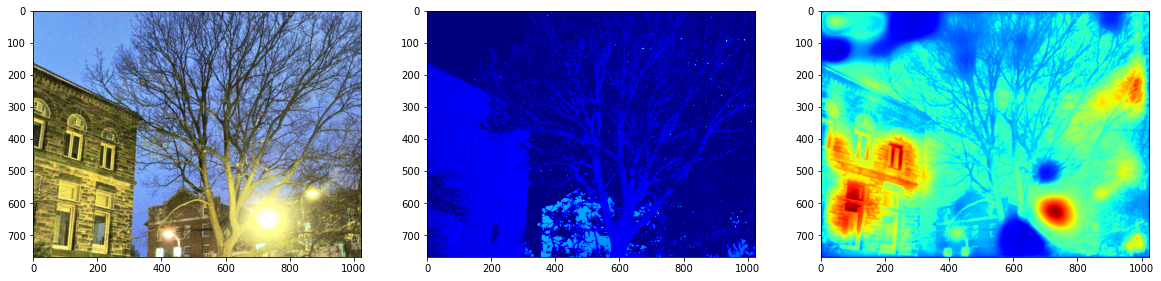

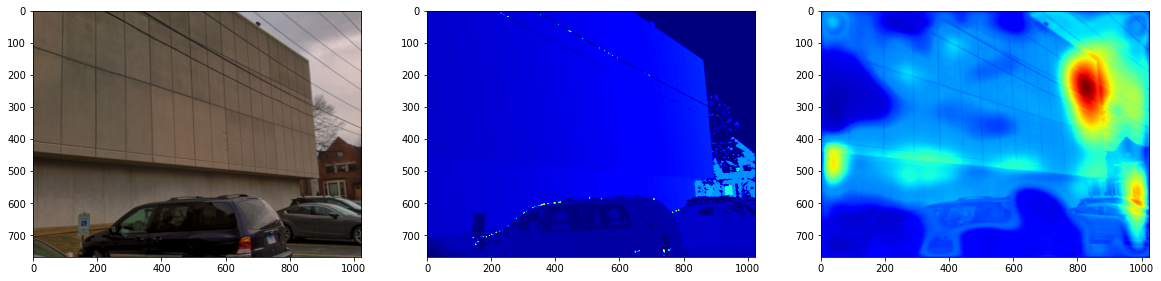

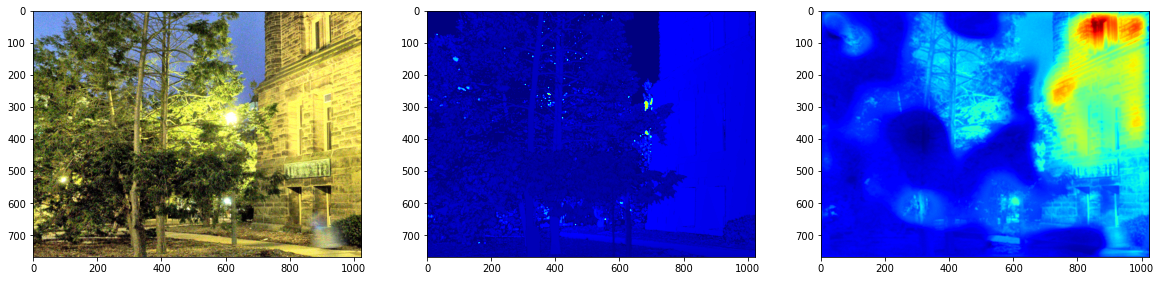

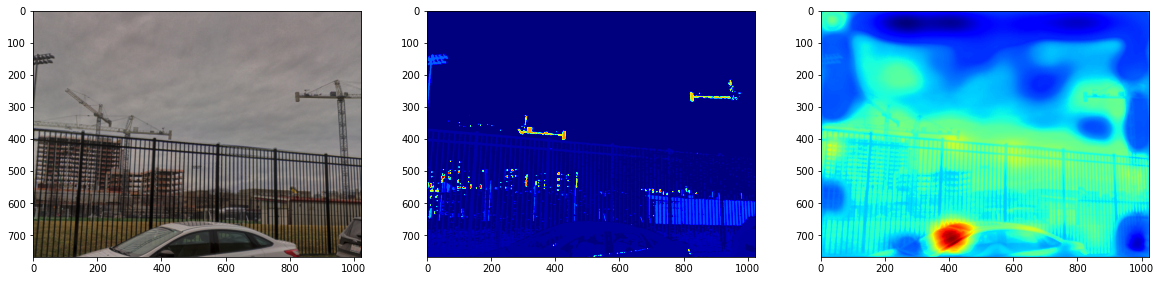

In [34]:
from local.utils import visualize_depth_map
from piqa import SSIM
from torchvision.transforms.functional import adjust_sharpness
import numpy as np


for batch_index, batch in enumerate(test_dataset):
    input, target, mask = batch["input"], batch["target"], batch["mask"]

    with torch.set_grad_enabled(False):
        output = model(image_preprocess(input))

    criterion_target = torch.repeat_interleave(depth_preprocess(target), 3, dim=1)
    criterion_output = torch.repeat_interleave(output, 3, dim=1)
    print(
        SSIM(k1=0.01 * 2, k2=0.03 * 2, value_range=1000.)(adjust_sharpness(torch.clip(criterion_target, 0, 1000), 4), criterion_output),
        nn.MSELoss()(criterion_target, criterion_output),
    )

    input = np.transpose(input.squeeze(axis=0), (1, 2, 0))
    target = np.transpose(target.squeeze(axis=0), (1, 2, 0))
    output = np.transpose(output.squeeze(axis=0), (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))

    # target = np.ma.masked_where(~mask, target)
    visualize_depth_map(input, target, output)

    if batch_index == 3:
        break

In [35]:
from local.diode.utils import get_filelist, format_filelist

# Versus purely indoors (same scope training), the depth computations are more correct as expected
test_dataset = DataLoader(
    DIODEDataset(valid, image_transform=base_preprocess, depth_transform=base_preprocess), 
    batch_size=1, shuffle=True, num_workers=2
)

tensor(0.9869) tensor(0.6619)
tensor(0.9042) tensor(47.1459)
tensor(0.9774) tensor(4.3919)
tensor(0.9688) tensor(7.3683)


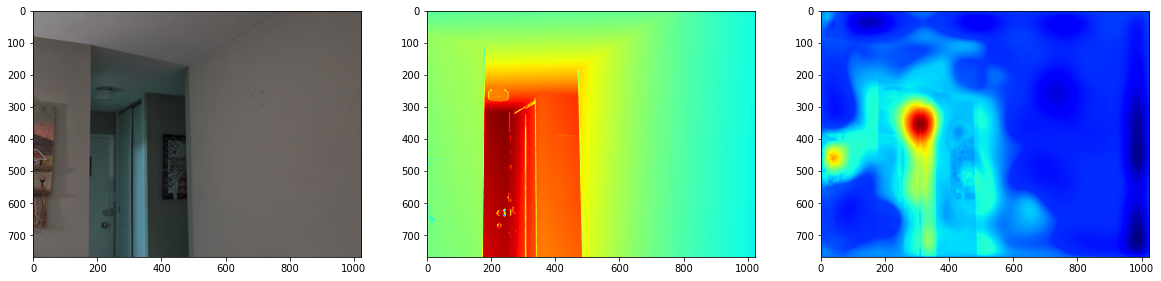

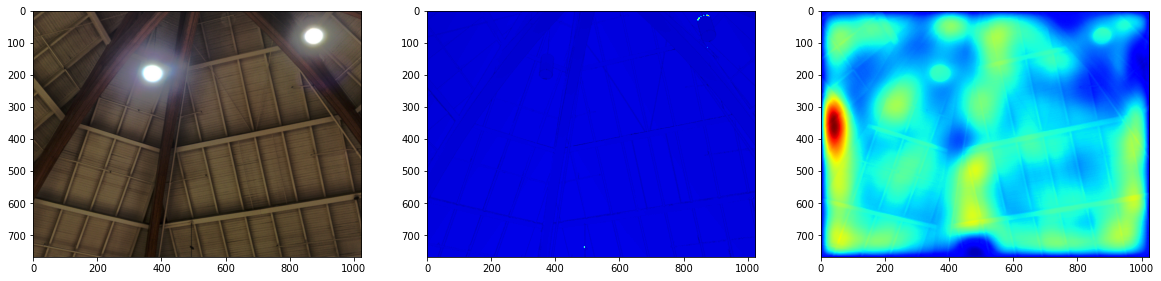

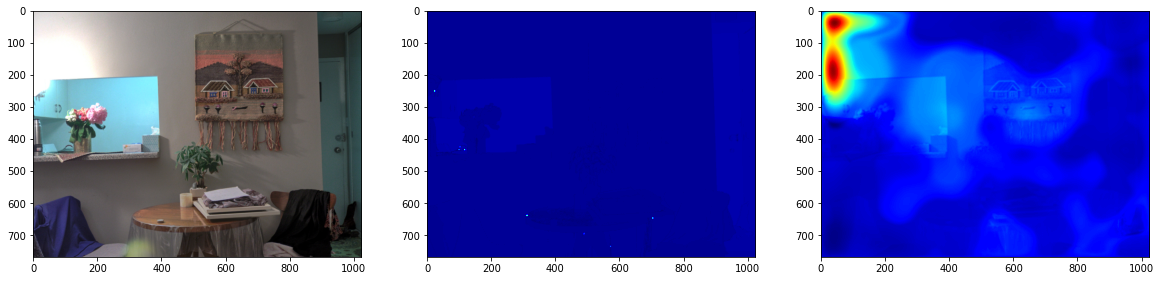

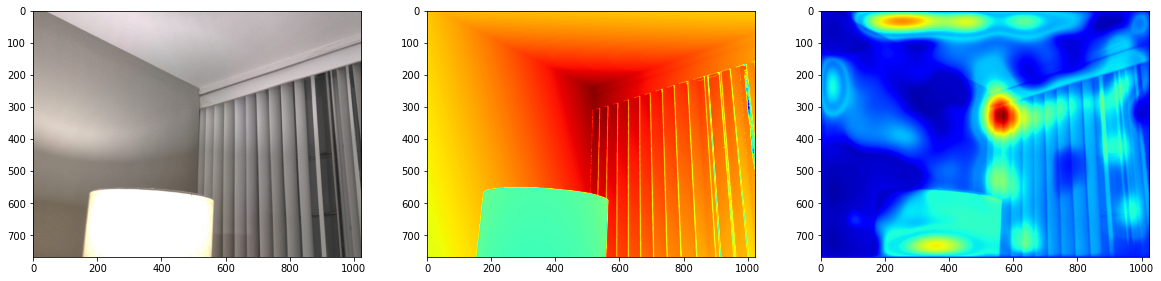

In [36]:
from local.utils import visualize_depth_map
from piqa import SSIM
from torchvision.transforms.functional import adjust_sharpness
import numpy as np


for batch_index, batch in enumerate(test_dataset):
    input, target, mask = batch["input"], batch["target"], batch["mask"]

    with torch.set_grad_enabled(False):
        output = model(image_preprocess(input))

    criterion_target = torch.repeat_interleave(depth_preprocess(target), 3, dim=1)
    criterion_output = torch.repeat_interleave(output, 3, dim=1)
    print(
        SSIM(k1=0.01 * 2, k2=0.03 * 2, value_range=1000.)(adjust_sharpness(torch.clip(criterion_target, 0, 1000), 4), criterion_output),
        nn.MSELoss()(criterion_target, criterion_output),
    )

    input = np.transpose(input.squeeze(axis=0), (1, 2, 0))
    target = np.transpose(target.squeeze(axis=0), (1, 2, 0))
    output = np.transpose(output.squeeze(axis=0), (1, 2, 0))
    mask = np.transpose(mask, (1, 2, 0))

    # target = np.ma.masked_where(~mask, target)
    visualize_depth_map(input, target, output)

    if batch_index == 3:
        break